# Simulation analysis

This notebook analyzes the evolution of a single bunch.

In [1]:
import os
from pprint import pprint
import sys

from ipywidgets import interact
from ipywidgets import widgets
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
from scipy import interpolate
from tqdm.notebook import tqdm
from tqdm.notebook import trange

sys.path.append("/home/46h/repo/psdist/")
import psdist as ps
import psdist.visualization as psv

In [2]:
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["colorbar.width"] = "1.2em"
pplt.rc["cycle"] = "538"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

## Setup

In [3]:
save = False

In [4]:
timestamp = 230901162221
folder = f"../../data/sns_btf/sim/{timestamp}"
sorted(os.listdir(folder))

['bunch_0000_START.dat',
 'bunch_0001_STOP.dat',
 'history.dat',
 'lattice_nodes.txt',
 'lattice_structure.txt',
 'log.txt',
 'losses.txt',
 'lostbunch.dat',
 'sim.py']

In [5]:
if save:
    outdir = f"../figures/{timestamp}/"
    if not os.path.isdir(outdir):
        os.makedirs(outdir)

def save_figure(filename):
    if not save:
        return
    filename = os.path.join(outdir, filename)
    plt.savefig(filename)

## Scalar history

Load node positions.

In [6]:
file = open(os.path.join(folder, f"lattice_nodes.txt"), "r")
nodes_dict = dict()
nodes_list = list()
last = offset = 0.0
for i, line in enumerate(file):
    if i == 0:
        continue
    name, position, length = line.rstrip().split()
    position = float(position)
    length = float(length)
    if position < last:
        offset = offset + last
    last = position
    position = position + offset
    nodes_dict[name] = [position, length]
    nodes_list.append([name, position, length])
file.close()

Load scalar history.

In [7]:
filename = os.path.join(folder, f"history.dat")
history = pd.read_csv(filename)
for index in range(history.shape[0]):
    Sigma = np.zeros((6, 6))
    for i in range(6):
        for j in range(i + 1):
            Sigma[i, j] = Sigma[j, i] = history.loc[index, f"cov_{j}-{i}"]
    history.loc[index, "eps_x"] = np.sqrt(np.linalg.det(Sigma[0:2, 0:2]))
    history.loc[index, "eps_y"] = np.sqrt(np.linalg.det(Sigma[2:4, 2:4]))
    history.loc[index, "eps_z"] = np.sqrt(np.linalg.det(Sigma[4:6, 4:6]))
    history.loc[index, "eps_xy"] = np.sqrt(np.linalg.det(Sigma[0:4, 0:4]))
    history.loc[index, "eps_xyz"] = np.sqrt(np.linalg.det(Sigma[:, :]))    
if ("mean_" in history.columns) and ("mean_3" not in history.columns):  # ?
    history.rename(columns={"mean_": "mean_3"}, inplace=True)
history["phi_max"] = -history["z_to_phase_coeff"] * history["z_max"]
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   y_rms             663 non-null    float64
 1   cov_1-1           663 non-null    float64
 2   energy            663 non-null    float64
 3   cov_1-3           663 non-null    float64
 4   cov_1-4           663 non-null    float64
 5   cov_3-3           663 non-null    float64
 6   n_parts           663 non-null    int64  
 7   z_rms             663 non-null    float64
 8   cov_3-4           663 non-null    float64
 9   cov_0-5           663 non-null    float64
 10  cov_4-5           663 non-null    float64
 11  cov_0-4           663 non-null    float64
 12  z_rms_deg         663 non-null    float64
 13  z_max             663 non-null    float64
 14  cov_1-5           663 non-null    float64
 15  cov_5-5           663 non-null    float64
 16  z_to_phase_coeff  663 non-null    float64
 1

### Energy 

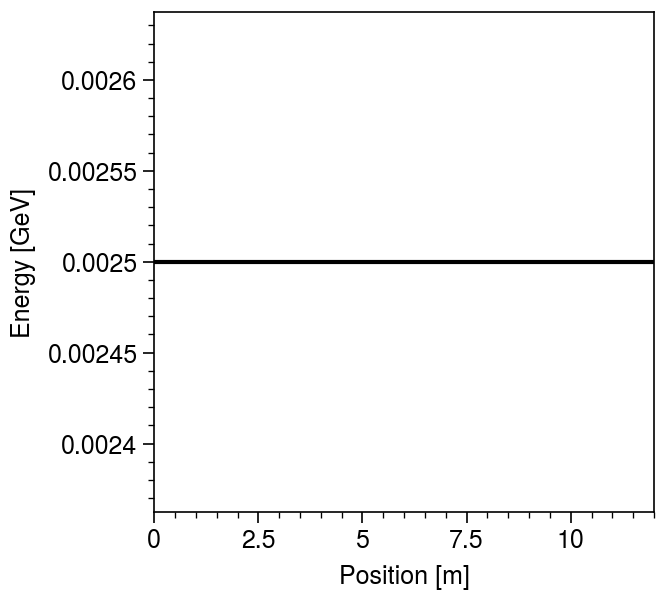

In [8]:
fig, ax = pplt.subplots()
ax.plot(history["position"], history["energy"], color="black")
ax.format(xlabel="Position [m]", ylabel="Energy [GeV]")
save_figure("energy")

### First-order moments 

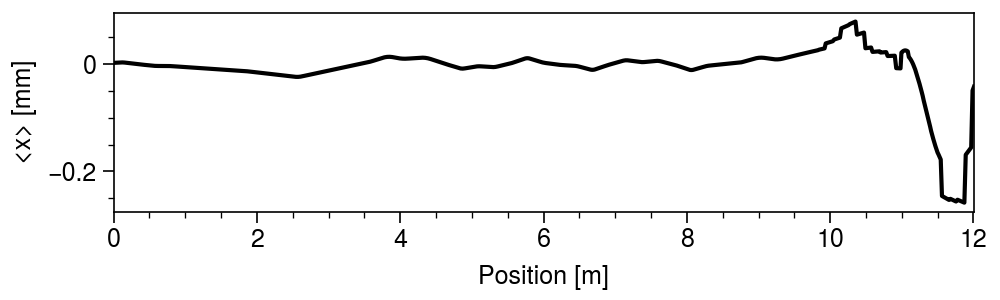

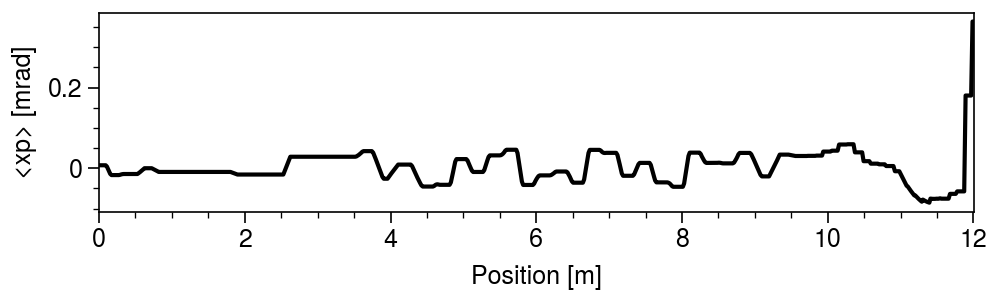

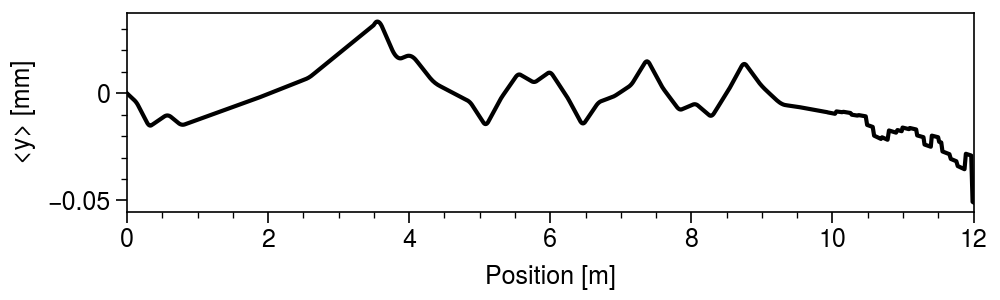

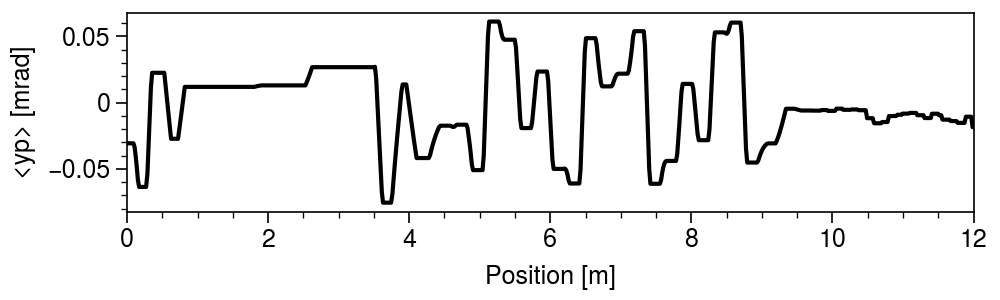

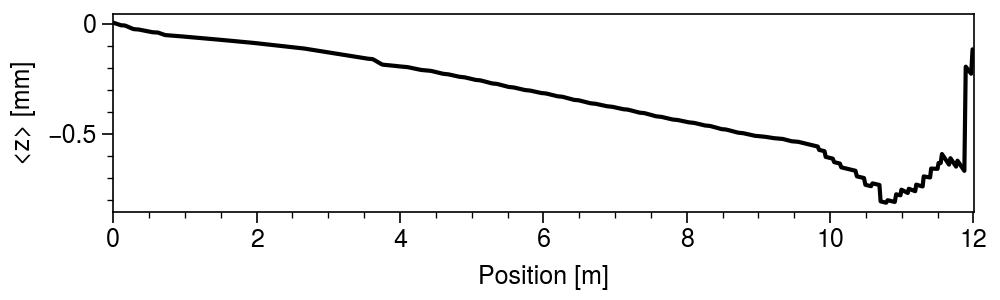

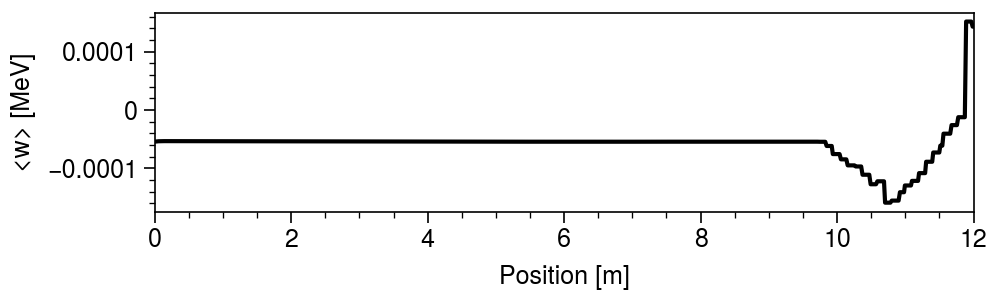

In [9]:
_dims = ["x", "xp", "y", "yp", "z", "w"]
_units = ["mm", "mrad", "mm", "mrad", "mm", "MeV"]
for i in range(6):
    fig, ax = pplt.subplots(figsize=(5.0, 1.5))
    ax.plot(
        history["position"],
        1000.0 * history[f"mean_{i}"],
        color="black",
    )
    ax.format(xlabel="Position [m]", ylabel=f"<{_dims[i]}> [{_units[i]}]")
    save_figure(f"mean_{i}")
    plt.show()

### Second-order moments

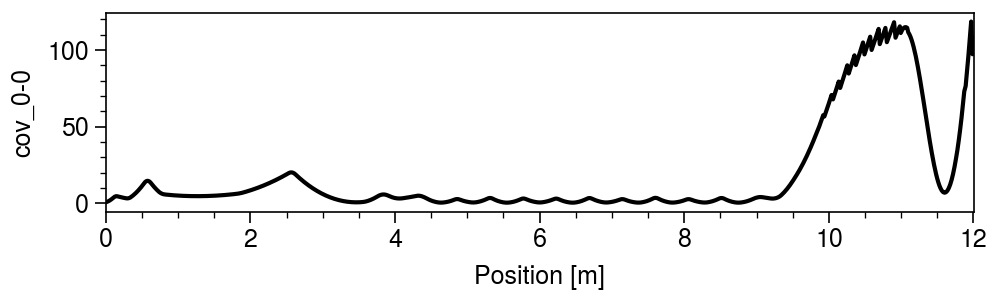

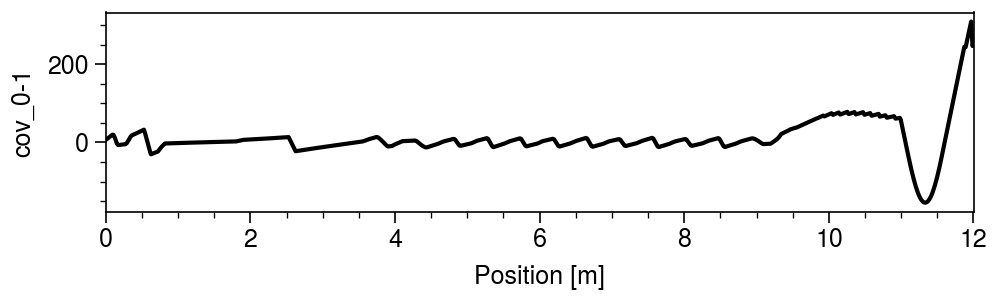

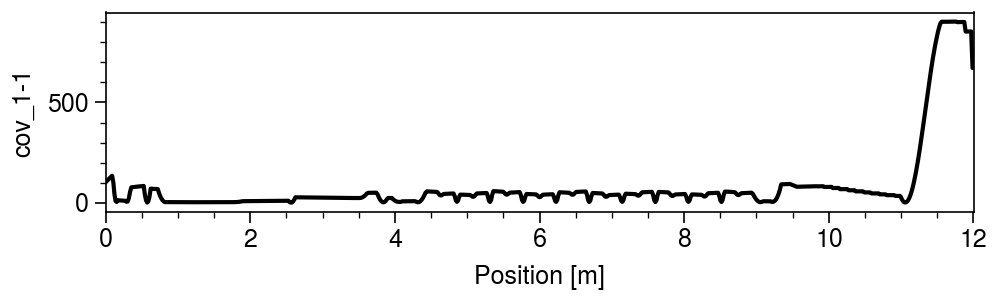

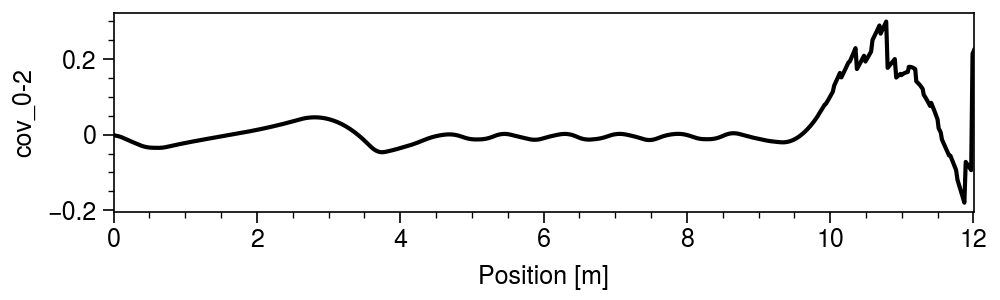

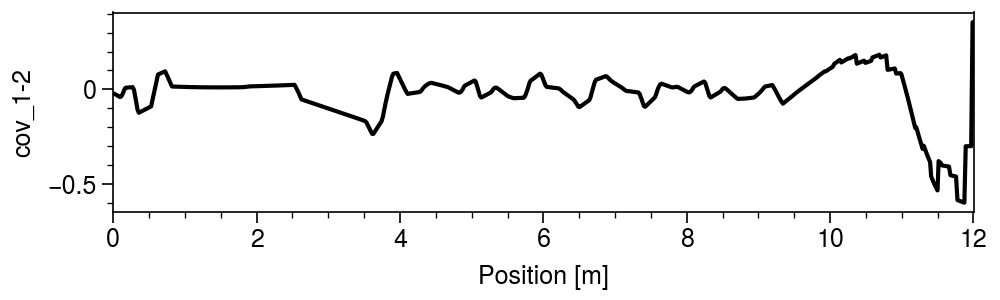

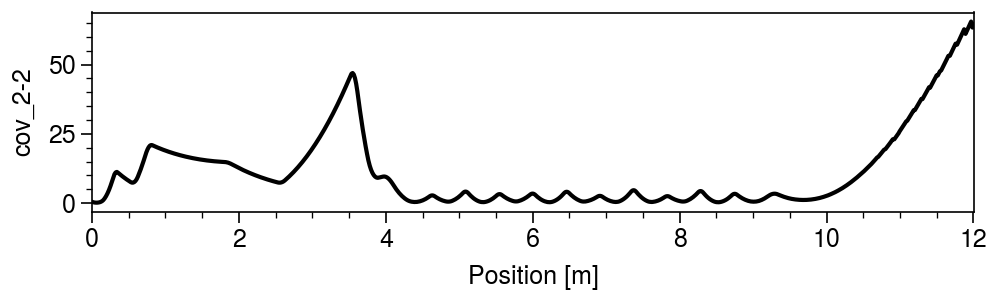

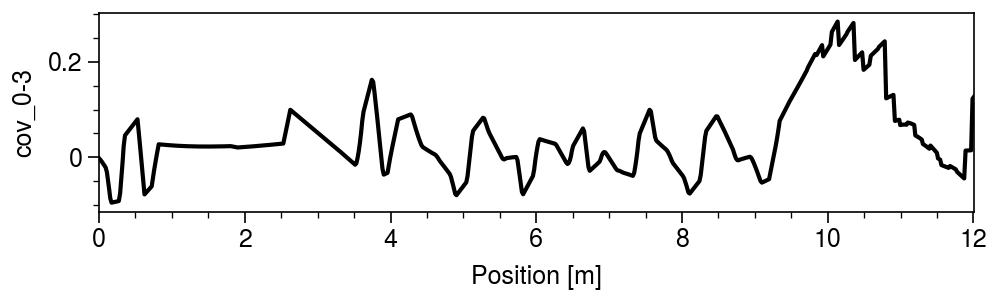

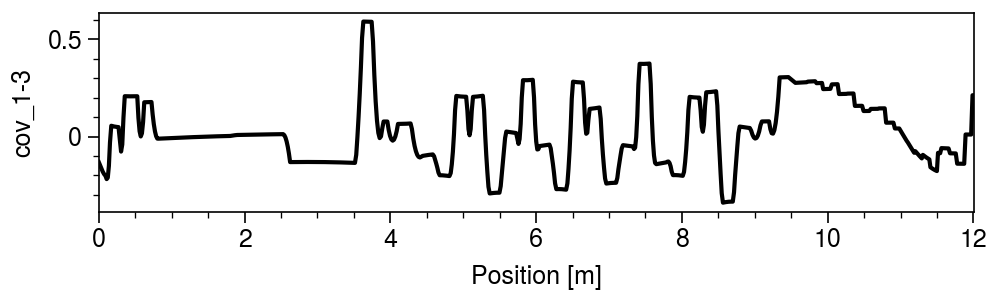

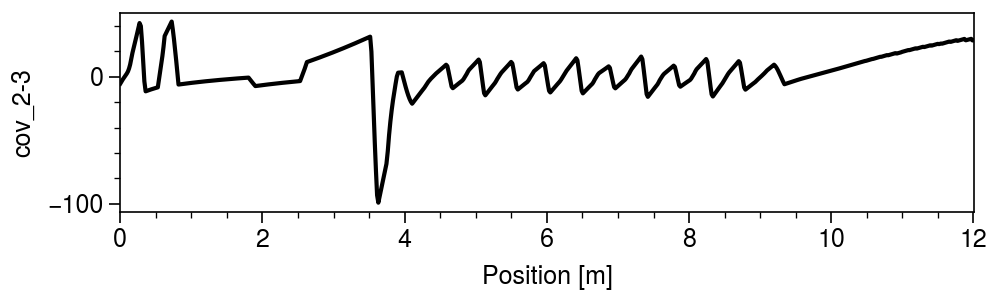

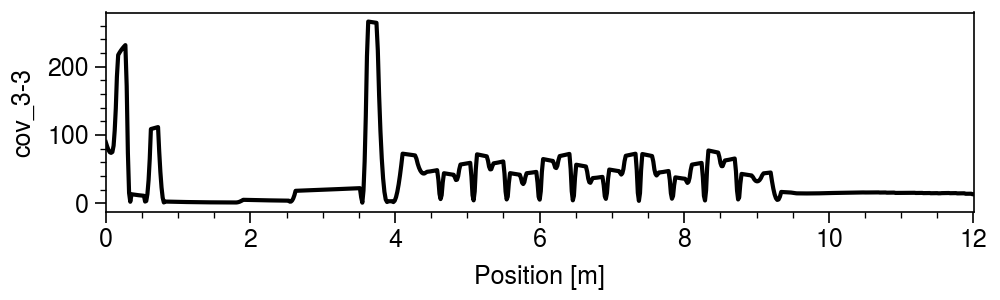

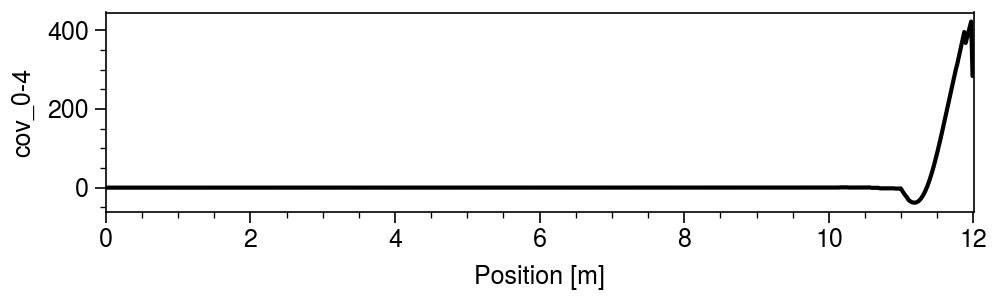

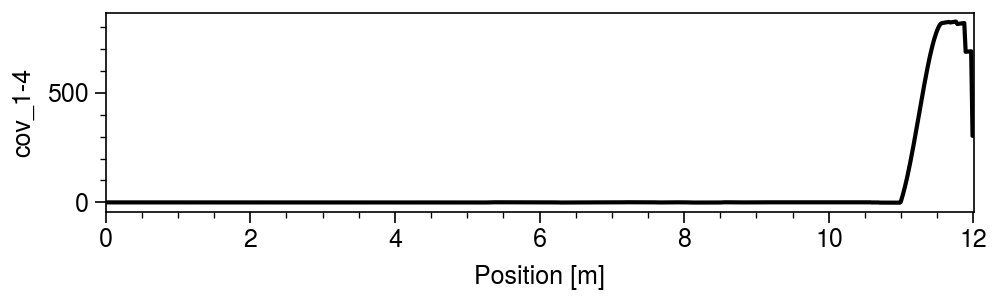

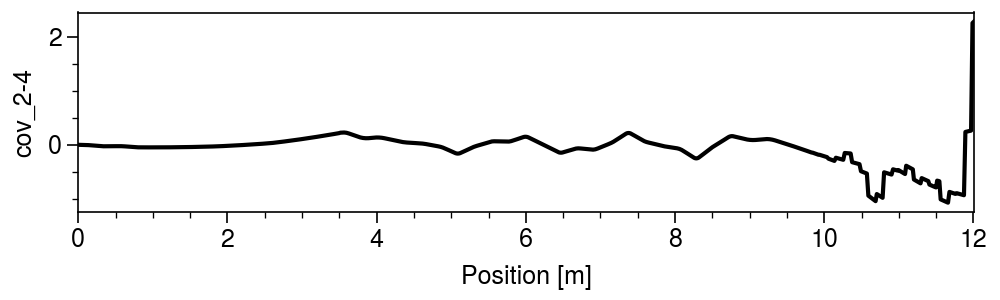

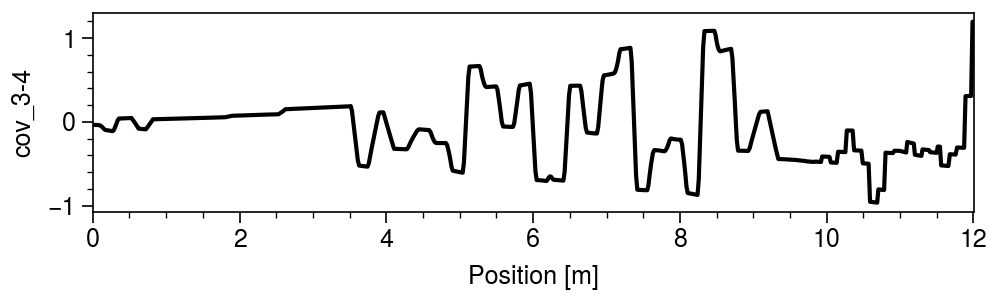

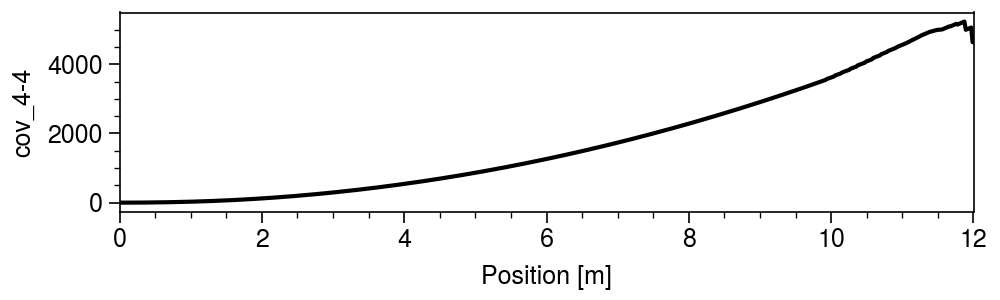

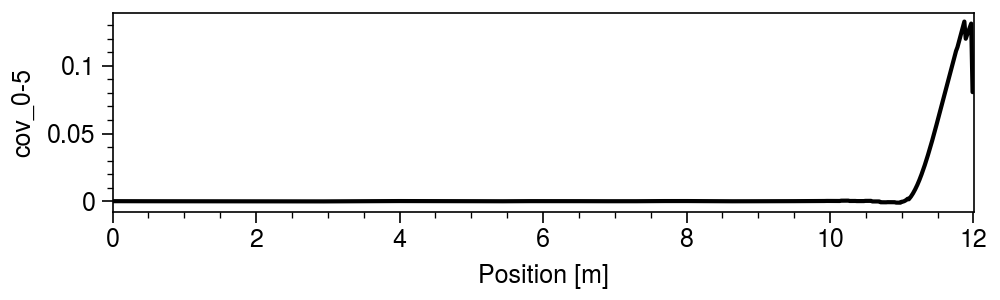

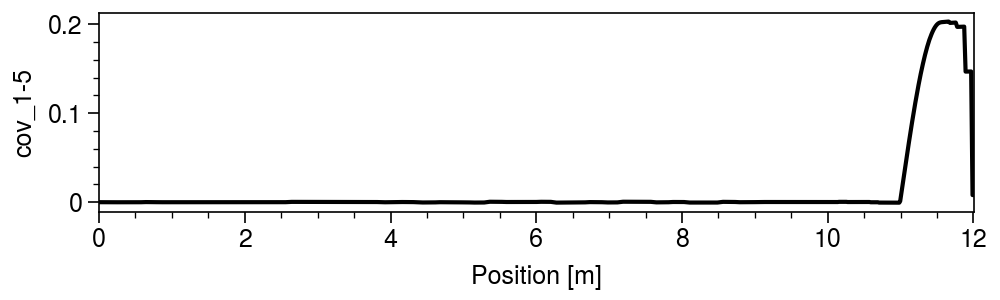

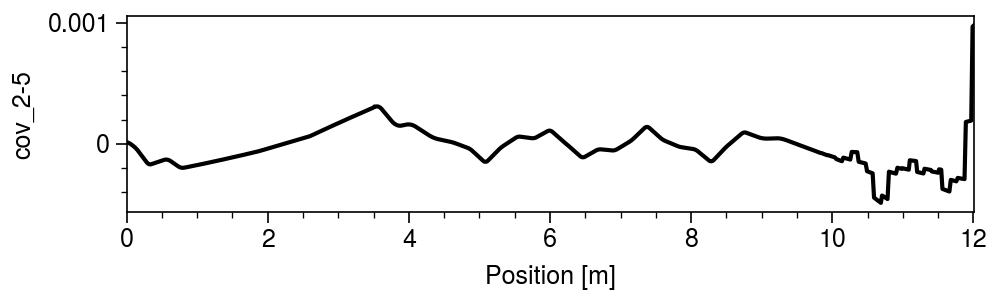

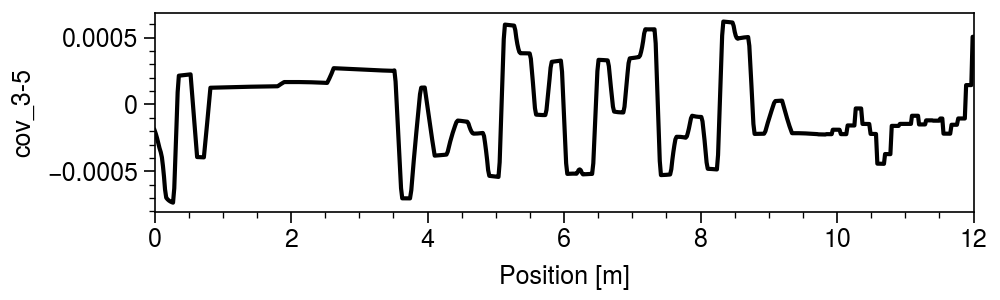

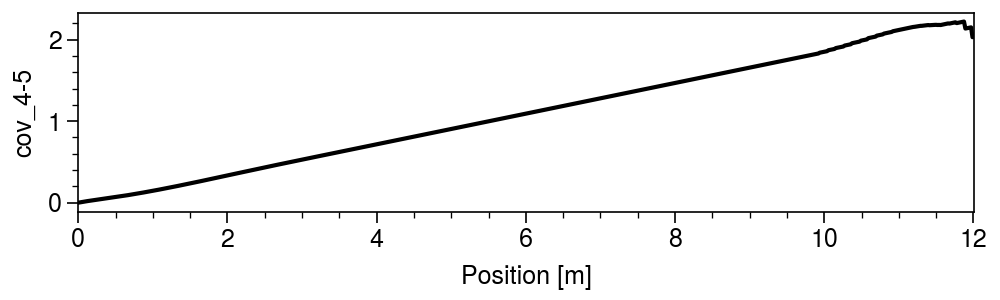

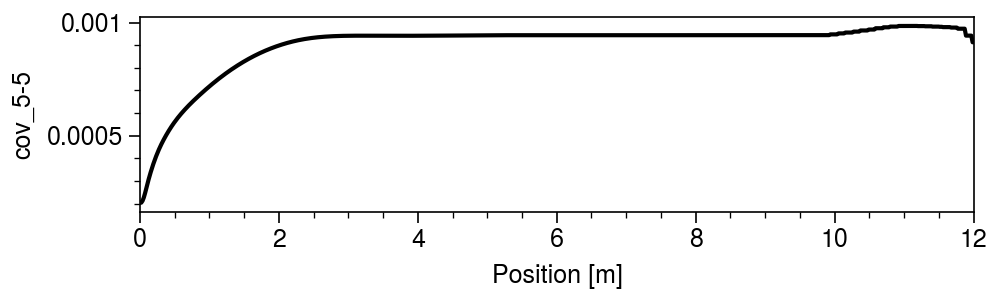

In [10]:
for i in range(6):
    for j in range(i + 1):
        fig, ax = pplt.subplots(figsize=(5.0, 1.5))
        ax.plot(
            history["position"],
            1.0e6 * history[f"cov_{j}-{i}"],
            color="black",
        )
        ax.format(xlabel="Position [m]")
        save_figure(f"cov_{j}-{i}")
        plt.show()

### Standard deviations

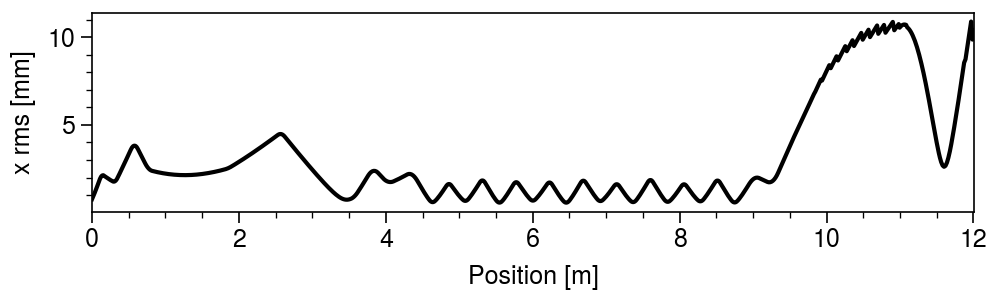

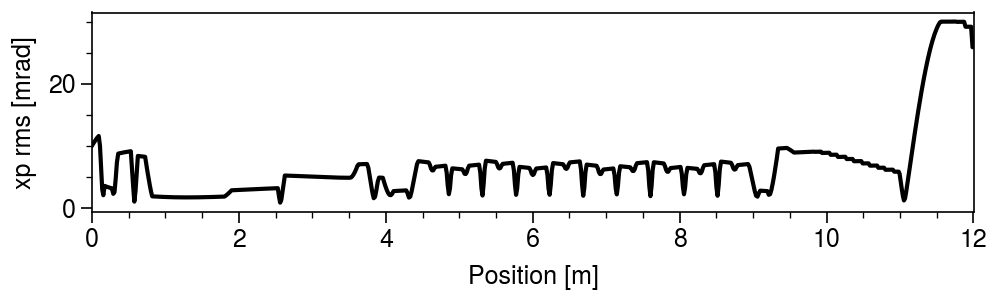

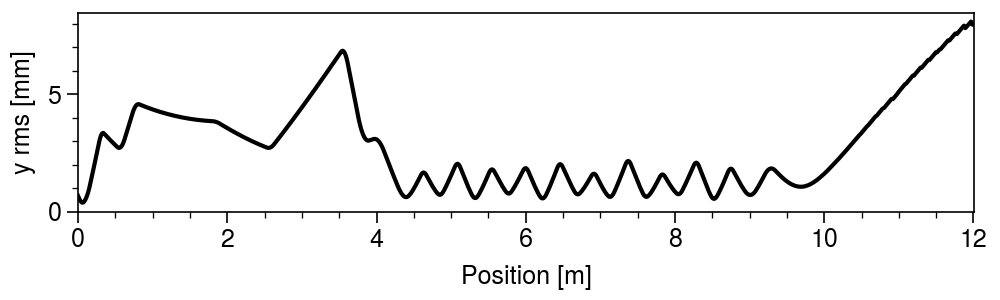

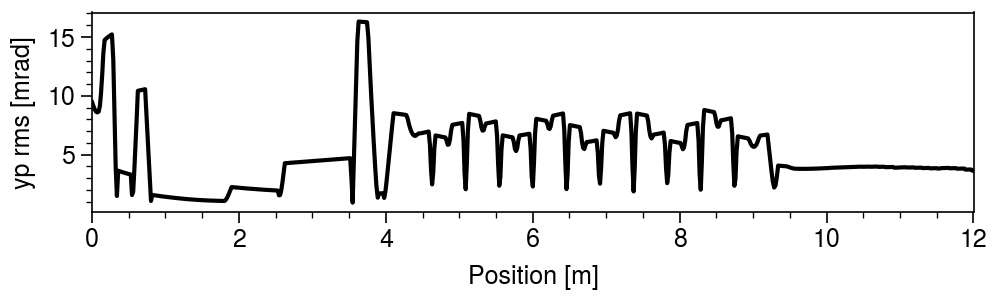

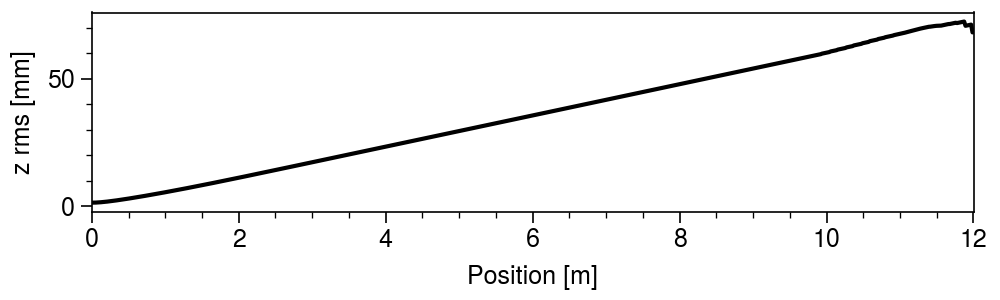

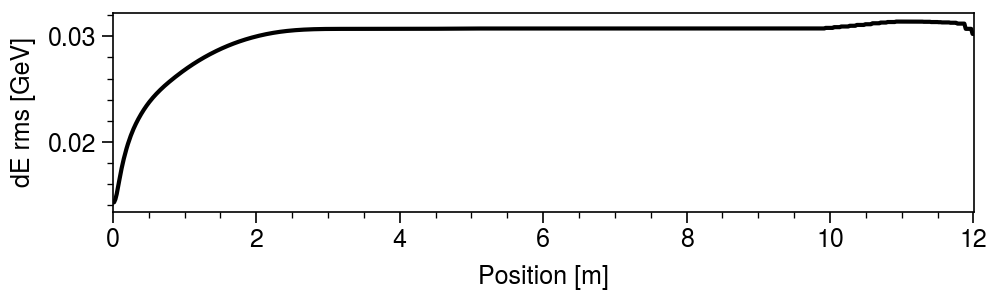

In [11]:
for i in range(6):
    fig, ax = pplt.subplots(figsize=(5.0, 1.5))
    ax.plot(
        history["position"],
        1.0e3 * np.sqrt(history[f"cov_{i}-{i}"]),
        color="black",
    )
    dims = ["x", "xp", "y", "yp", "z", "dE"]
    units = ["mm", "mrad", "mm", "mrad", "mm", "GeV"]
    ax.format(xlabel="Position [m]", ylabel=f"{dims[i]} rms [{units[i]}]")
    save_figure(f"rms_{i}")
    plt.show()

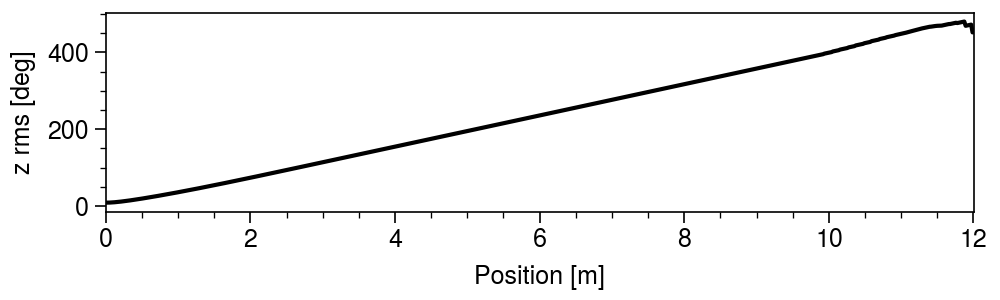

In [12]:
fig, ax = pplt.subplots(figsize=(5.0, 1.5))
ax.plot(
    history["position"],
    history["z_rms_deg"],
    color="black",
)
ax.format(xlabel="Position [m]", ylabel="z rms [deg]")
save_figure(f"rms_4_deg")
plt.show()

### Emittances 

In [ ]:
for tag in ["x", "y", "z", "xy", "xyz"]:
    factor = 1.0
    if tag in ["x", "y", "z"]:
        factor = 1.00e+06
    if tag == "xy":
        factor = 1.00e+12
    elif tag == "xyz":
        factor = 1.00e+18
        
    fig, ax = pplt.subplots(figsize=(5.0, 1.75))
    ax.plot(
        history["position"],
        factor * history[f"eps_{tag}"],
        color="black",
    )
    ax.format(xlabel="Position [m]", ylabel="eps_{}".format(tag))
    save_figure(f"eps_{tag}")
    plt.show()

### Extrema 

In [ ]:
history["phi_rms"] = history["z_rms_deg"]

for dim, unit in zip(["x", "y", "phi"], ["mm", "mm", "deg"]):
    fig, ax = pplt.subplots(figsize=(5.0, 1.5))
    factor = 1.0
    if dim in "xy":
        factor = 1000.0
    ax.fill_between(
        history["position"],
        0.0,
        factor * history[f"{dim}_max"],
        color="black",
        alpha=0.25,
        ec="None",
        label="max",
    )
    ax.fill_between(
        history["position"],
        0.0,
        factor * history[f"{dim}_rms"],
        color="black",
        label="rms",
    )
    ax.legend(loc="r", ncols=1, framealpha=0.0)
    ax.format(xlabel="Position [m]", ylabel=f"{dim} [{unit}]")
    save_figure(f"extrema_rms_{dim}")
    plt.show()

## Phase space distribution 

### Load bunches

Collect bunch file names.

In [ ]:
bunch_filenames = os.listdir(folder)
bunch_filenames = [f for f in bunch_filenames if timestamp in f]
bunch_filenames = [f for f in bunch_filenames if "bunch" in f]
bunch_filenames = [f for f in bunch_filenames if "lostbunch" not in f]
bunch_filenames = [f for f in bunch_filenames if "smallbunch" not in f]
bunch_filenames = sorted(bunch_filenames)
bunch_filenames = [os.path.join(folder, f) for f in bunch_filenames]

bunch_filenames = bunch_filenames[::2]

n_frames = len(bunch_filenames)

pprint(bunch_filenames)

For each bunch, find its index in the history array. This tells us the position, node, energy, etc. for each bunch. We can then convert z to phi if we want.

In [ ]:
bunch_history_indices = []
for frame, filename in enumerate(bunch_filenames):
    node = filename.split("bunch_")[-1].split(".dat")[0]
    node = node[(node.find("_") + 1):]
    if node == "START":
        index = 0
    elif node == "STOP":
        index = history.shape[0] - 1
    else:
        index = history["node"].tolist().index(node)
    bunch_history_indices.append(index)
    print(f"frame={frame}, node={node}, history_index={index}")

Load the phase space coordinates.

In [ ]:
bunches = []
columns = ["x", "xp", "y", "yp", "z", "w", "index", "x0", "xp0", "y0", "yp0", "z0", "w0"]
for frame, filename in enumerate(tqdm(bunch_filenames)):
    bunch = np.loadtxt(filename, comments="%", max_rows=None)
    # Convert [m, rad, m, rad, m, GeV] -> [mm, mrad, mm, mrad, mm, MeV]
    bunch[:, :6] *= 1.00e+03
    if bunch.shape[1] >= 13:
        bunch[:, 7:13] *= 1.00e+03
    # Create DataFrame.
    bunch = pd.DataFrame(bunch, columns=columns[:bunch.shape[1]])
    if "index" in bunch.columns:
        bunch["index"] = bunch["index"].astype(int)
    # Convert z --> phi.
    j = bunch_history_indices[frame]
    z_to_phase_coeff = history.loc[j, "z_to_phase_coeff"]
    bunch["phi"] = -z_to_phase_coeff * 0.001 * bunch["z"]
    if "z0" in bunch:
        bunch["phi0"] = -z_to_phase_coeff * 0.001 * bunch["z0"]
    bunches.append(bunch)

### 1D projections

Decide on units.

In [ ]:
use_phi = True
dims = ["x", "xp", "y", "yp", "z", "w"]
units = ["mm", "mrad", "mm", "mrad", "mm", "MeV"]
if use_phi:
    dims[4] = "phi"
    units[4] = "deg"
dims_units = [f"{dim} [{unit}]" for dim, unit in zip(dims, units)]

#### Partial projections [INT]

In [ ]:
psv.cloud.proj1d_interactive_slice(
    data=[bunch.loc[:, dims].values for bunch in bunches],
    dims=dims,
    units=units,
    autolim_kws=dict(pad=0.1, zero_center=True, sigma=None, share=None),
    color="black",
)

#### Full projections

The following cell saves all 1D projections of the phase space distribution at each frame.

In [ ]:
if save:
    bins = 85
    for frame, bunch in enumerate(tqdm(bunches)):
        X = bunch.loc[:, dims].values
        X_scaled = X / np.std(X, axis=0)
        limits = psv.cloud.auto_limits(X_scaled, pad=0.1, zero_center=True)
        for i in range(X.shape[1]):
            profile, edges = np.histogram(X_scaled[:, i], bins, limits[i])
            profile = profile / np.max(profile)
            fig, ax = pplt.subplots()
            psv.plot_profile(
                profile=profile,
                edges=edges,
                ax=ax,
                color="black",
                kind="step",
                lw=1.5,
            )
            ax.format(yscale="log", yformatter="log")
            ax.format(xlabel=r"{} / $\sigma$".format(dims[i]))
            save_figure(f"proj1d_{i}_{frame}")
            plt.close()

### 2D projections 

#### Partial projections [INT]

In [ ]:
psv.cloud.proj2d_interactive_slice(
    data=[bunch.loc[:, dims].values for bunch in bunches],
    dims=dims,
    units=units,
    autolim_kws=dict(zero_center=True, sigma=None, share=None),
    options=dict(
        log=True,
        mask=True,
        normalize=True,
        ellipse=True,
        profiles=True,
    ),
    process_kws=dict(norm="max"),
    colorbar=True,
    colorbar_kw=dict(tickminor=True),
)

#### Full projections (joint plot)

In [ ]:
if save:
    bins = 85
    for frame, bunch in enumerate(tqdm(bunches)):
        X = ps.cloud.norm_xxp_yyp_zzp(
            bunch.loc[:, dims].values,
            scale_emittance=True,
        )
        limits = psv.cloud.auto_limits(X, pad=0.1, zero_center=True)
        for i in range(X.shape[1]):
            for j in range(i):
                axis = (j, i)
                grid = psv.JointGrid(
                    marg_kws=dict(space="2.0em", width="13.0em"),
                    marg_fmt_kws_x=dict(yspineloc="left", xspineloc="bottom"),
                    marg_fmt_kws_y=dict(yspineloc="left", xspineloc="bottom"),
                    xspineloc="bottom",
                    yspineloc="left",
                )
                grid.plot_cloud(
                    X[:, axis], 
                    kind="hist",
                    bins=bins,
                    limits=[limits[k] for k in axis],
                    marg_kws=dict(scale="max"),
                    marg_hist_kws=dict(bins=bins),
                    process_kws=dict(norm="max"),
                    offset=1.0,
                    norm="log",
                    colorbar=True,
                    colorbar_kw=dict(tickminor=True, width="1.2em"),
                )
                ymin = 10.0**-6.0
                ymax = 2.0
                grid.ax_marg_x.format(yformatter="log", yscale="log")
                grid.ax_marg_y.format(xformatter="log", xscale="log")
                grid.ax_marg_x.format(ymin=ymin, ymax=ymax)
                grid.ax_marg_y.format(xmin=ymin, xmax=ymax)
                grid.ax.format(xlabel=dims[axis[0]], ylabel=dims[axis[1]])
                save_figure(f"proj2d_{axis[0]}-{axis[1]}_{frame}")
                plt.close()

### Corner plots

In [ ]:
if save:
    for i, bunch in enumerate(tqdm(bunches)):
        X = ps.cloud.norm_xxp_yyp_zzp(
            bunch.iloc[:, :6].values,
            scale_emittance=True,
        )
        grid = psv.CornerGrid(d=6, labels=dims, corner=True, diag_rspine=True, space=1.4)
        grid.plot_cloud(
            X, 
            lower=True, 
            upper=False,     
            autolim_kws=dict(pad=0.1, zero_center=True), 
            kind="hist",
            bins=100,
            offset=1.0,
            norm="log",
            cmap="viridis",
        )
        grid.format_diag(yscale="log", yformatter="log", ymin=(10.0 ** -6.0))
        save_figure(f"corner_log_{i}")
        plt.show()

### Radial density

Here we compute the density within spherical shells.

#### Interactive [INT]

In [ ]:
@interact(
    frame=widgets.BoundedIntText(min=0, max=(len(bunches) - 1), value=0),
    bins=(25, 75),
    log=True,
    x=True,
    px=True,
    y=False,
    py=False,
    z=False,
    pz=False,
)
def update_radial_density(frame, bins, log, x, px, y, py, z, pz):
    bunch = bunches[frame]
    X = ps.cloud.norm_xxp_yyp_zzp(bunch.loc[:, dims].values, scale_emittance=True) 
    axis = tuple([i for i, check in enumerate([x, px, y, py, z, pz]) if check])

    fig, ax = pplt.subplots()
    hist_r, edges_r = ps.cloud.radial_histogram(X[:, axis], bins=bins, centers=False)
    hist_r = hist_r / np.sum(hist_r * np.diff(edges_r))
    centers_r = ps.utils.centers_from_edges(edges_r)
    ax.plot(centers_r, hist_r, drawstyle="steps-mid", color="black")
    ax.format(
        xmin=0.0,
        xlabel="radius", ylabel="density",
        title=f"axis={axis}", title_kw=dict(fontsize="medium"),
    )

    ymin = min(hist_r[hist_r > 0])
    ax.plot(centers_r, np.exp(-0.5 * (centers_r**2)), color="black", alpha=0.2)
    ax.format(ymin=ymin)

    if log:
        ax.format(yscale="log", yformatter="log")
    return ax

In [ ]:
axis_list_all = []
for i in range(6):
    for j in range(i):
        axis_list_all.append((j, i))
        for k in range(j):
            axis_list_all.append((k, j, i))
            for l in range(k):
                axis_list_all.append((l, k, j, i))
                for m in range(l):
                    axis_list_all.append((m, l, k, j, i))
axis_list_all.append((0, 1, 2, 3, 4, 5))

In [ ]:
axis_list = [
    (0, 1),
    (2, 3),
    (4, 5),
    (0, 1, 2, 3),
    (0, 1, 4, 5),
    (2, 3, 4, 5),
    (0, 1, 2, 3, 4, 5),
]

In [ ]:
if save:
    for frame in tqdm(range(n_frames)):
        for axis in tqdm(axis_list):
            switches = 6 * [False]
            for k in axis:
                switches[k] = True
            x, xp, y, yp, z, pz = switches
            ax = update_radial_density(
                frame=frame,
                bins=50,
                log=True,
                x=switches[0],
                px=switches[1],
                y=switches[2],
                py=switches[3],
                z=switches[4],
                pz=switches[5],
            )
        
            _dims = [r"x", r"x'", "y", "y'", "z", "z'"]
            xlabel = "-".join([_dims[k] for k in axis])
            xlabel = f"Radius ({xlabel})"
            ax.format(yscale="log", yformatter="log", xlabel=xlabel, ylabel="Density", xmin=0.0)
            ax.legend(loc="upper right", ncols=1)
        
            tag = "-".join([str(k) for k in axis])
            save_figure(f"radial_{tag}_{frame}")
            plt.close()

## Losses

### Scalar

In [ ]:
apertures = pd.read_csv(os.path.join(folder, f"{prefix}_losses.txt"), sep=" ")
apertures

In [ ]:
apertures["loss"].sum()

In [ ]:
fig, ax = pplt.subplots(figsize=(5.0, 2.0))
ax.plot(
    history["position"],
    abs(history["n_parts"] - history.loc[0, "n_parts"]),
    color="black",
)
ax.format(xlabel="Position [m]", ylabel="Loss (cumulative)")
save_figure("loss_cumulative")
plt.show()

### Phase space distribution

Get lost bunch filename.

In [ ]:
filenames = [f for f in os.listdir(folder) if timestamp in f and "lostbunch" in f ]
filenames = [os.path.join(folder, f) for f in filenames]
filename = filenames[0]
filename

Load lost bunch.

In [ ]:
lostbunch = np.loadtxt(filename, comments="%")
lostbunch[:, :6] *= 1000.0    
lostbunch = pd.DataFrame(lostbunch, columns=["x", "xp", "y", "yp", "z", "dE", "s", "index"])
lostbunch["index"] = lostbunch["index"].astype(int)
lostbunch = lostbunch.sort_values("s")
z_to_phase_interp = interpolate.interp1d(
    history["position"], history["z_to_phase_coeff"], kind="linear"
)
lostbunch["phi"] = -z_to_phase_interp(lostbunch["s"]) * 0.001 * lostbunch["z"]
lostbunch

Check lost bunch vs. number of surviving particles.

In [ ]:
fig, ax = pplt.subplots(figsize=(5.0, 1.7))
ax.plot(history["position"], abs(history["n_parts"] - history.loc[0, "n_parts"]), color="black")
ax.format(xlabel="Position [m]", ylabel="Loss (cumulative)")
for s in lostbunch["s"].values:
    ax.axvline(s, color="red2")
save_figure("loss_check_positions")
plt.show()

#### Lost r-z coordinates

In [ ]:
lostbunch["r"] = np.sqrt(lostbunch["x"]**2 + lostbunch["y"]**2)

fig, ax = pplt.subplots()
ax.scatter(
    lostbunch["phi"], 
    lostbunch["r"], 
    c=lostbunch["s"], 
    cmap=pplt.Colormap("blues", left=0.1), 
    s=8.0,
    colorbar=True,
    colorbar_kw=dict(width="1.1em", label="s [m]"),
)
ax.format(xlabel=r"phi [deg]", ylabel="radius [mm]")
save_figure("loss_rz")

#### Transverse/longitudinal 

Group lost particles into "small z" and "large z" groups to isolate transverse vs. longitudinal losses.

In [ ]:
phi_max = 89.0  # [deg]
index = lostbunch["index"].values
abs_phi = np.abs(lostbunch["phi"].values)
lost_index = {
    "all": index,
    "transverse": index[abs_phi <= phi_max],
    "longitudinal": index[abs_phi > phi_max],
}

Plot loss histogram.

In [ ]:
smin = 0.0  # start at lattice entrance
smax = nodes_list[-1][1]  # stop at last node
bins = np.linspace(smin, smax, 50)

for log in [False, True]:
    fig, axs = pplt.subplots(
        figsize=(5.0, 3.0),
        nrows=3,
        spany=False,
        aligny=True,
        height_ratios=[0.5, 1.0, 1.0],
        hspace=[0.0, None],
    )
    for row, ax in enumerate(axs[1:]):
        if row == 0:
            idx = np.abs(lostbunch["phi"].values) <= phi_max
            ax.format(ylabel="Loss (xy)")
        else:
            idx = np.abs(lostbunch["phi"].values) > phi_max
            ax.format(ylabel="Loss (z)")
        ax.hist(
            lostbunch.loc[idx, "s"].values,
            bins=bins,
            histtype="stepfilled",
            lw=1.5,
            alpha=0.99,
            color="black",
        )
    axs[1].legend(loc="r", ncols=1, framealpha=0.0)
    
    # Add labels for each linac sequence.
    sequences = [
        [nodes_dict["MEBT_START"][0], nodes_dict["MEBT_END"][0], "MEBT"],
        [nodes_dict["DTL1_START"][0], nodes_dict["DTL1_END"][0], "DTL1"],
        [nodes_dict["DTL2_START"][0], nodes_dict["DTL2_END"][0], "DTL2"],
        [nodes_dict["DTL3_START"][0], nodes_dict["DTL3_END"][0], "DTL3"],
        [nodes_dict["DTL4_START"][0], nodes_dict["DTL4_END"][0], "DTL4"],
        [nodes_dict["DTL5_START"][0], nodes_dict["DTL5_END"][0], "DTL5"],
        [nodes_dict["DTL6_START"][0], nodes_dict["DTL6_END"][0], "DTL6"],
    ]
    cmap = pplt.Colormap("mono")
    _colors = [cmap(i) for i in np.linspace(0.15, 0.9, len(sequences))]
    for i, (start, stop, label) in enumerate(sequences):
        mid = 0.5 * (start + stop)
        axs[0].plot([start, stop], [0.0, 0.0], color=_colors[i], lw=5)
        axs[0].annotate(
            label,
            xy=(mid, 0.5),
            horizontalalignment="center",
            color=_colors[i],
            fontweight="normal",
            fontsize="med-small",
        )
    
    axs[0].format(xspineloc="neither", yspineloc="neither", ylim=(-1.0, 1.0))
    axs.format(xmin=smin, xmax=smax, xlabel="Position [m]")
    if log:
        axs[1:].format(yscale="log", yformatter=None)
    save_figure(f"loss_position_hist_rz_seq_{log}")
    plt.show()

### Lost particle location in initial distribution 

#### 2D projections

Plot the bunch at different frames with particles that are eventually lost highlighted.

In [ ]:
n_lost_max = lostbunch.shape[0]


@interact(
    frame=widgets.BoundedIntText(min=0, max=len(bunches)-1, value=0),
    dim1=widgets.Dropdown(options=dims, value=dims[-2]),
    dim2=widgets.Dropdown(options=dims, value=dims[-1]),
    normalize=False,
    mask=True,
    log=True,
    bins=widgets.BoundedIntText(min=32, max=200, value=64, continuous_update=False),
    size=widgets.FloatSlider(min=1.0, max=15.0, value=4.0, continuous_update=False),
    nplot=widgets.IntSlider(
        min=0, max=n_lost_max, continuous_update=False, value=n_lost_max
    ),
    plot_xy=True,
    plot_z=True,
)
def update_highlight_loss(frame, dim1, dim2, normalize, mask, log, bins, size, nplot, plot_xy, plot_z):
    if dim1 == dim2:
        return
    axis = [dims.index(dim) for dim in [dim1, dim2]]

    bunch = bunches[frame]
    X = bunch.loc[:, dims].values
    X = X[:, axis]
    if normalize:
        X = ps.cloud.norm_xxp_yyp_zzp(X, scale_emittance=True)
    
    fig, ax = pplt.subplots()
    psv.cloud.plot2d(
        X,
        ax=ax,
        bins=bins,
        limits=psv.cloud.auto_limits(X, pad=0.1, zero_center=True),
        process_kws=dict(norm="max"),
        offset=(0.0 if mask else 1.0),
        mask=mask,
        vmax=1.0,
        cmap=pplt.Colormap("mono", left=0.04, right=0.9),
        colorbar=True,
        colorbar_kw=dict(tickminor=True, width="1.2em"),
        norm=("log" if log else None),
    )
    if plot_xy:
        if frame == 0:
            idx = lost_index["transverse"]
        else:
            idx = []
            for i in lost_index["transverse"]:
                _index = bunch[bunch["index"] == i].index
                if len(_index) == 1:
                    idx.append(int(_index[0]))                
        idx = idx[:nplot]
        psv.cloud.plot2d(
            X[idx, :],
            ax=ax,
            kind="scatter",
            c="pink",
            s=size,
            label="lost_xy",
        )
    if plot_z:
        if frame == 0:
            idx = lost_index["longitudinal"]
        else:
            idx = []
            for i in lost_index["longitudinal"]:
                _index = bunch[bunch["index"] == i].index
                if len(_index) == 1:
                    idx.append(int(_index[0]))
        idx = idx[:nplot]
        psv.cloud.plot2d(
            X[idx, :],
            ax=ax,
            kind="scatter",
            c="green",
            s=size,
            label="lost_z",
        )
    ax.format(xlabel=dims[axis[0]], ylabel=dims[axis[1]])
    ax.legend(loc="r", ncols=1, handlelength=1.0, ms=5)
    return ax

In [ ]:
if save:
    for frame in trange(len(bunches)):
        for i in range(6):
            for j in range(i):
                ax = update_highlight_loss(
                    frame, dims[j], dims[i]
                    normalize=False, 
                    mask=True, 
                    log=True, 
                    bins=105, 
                    size=3.5, 
                    nplot=999999, 
                    plot_xy=True, 
                    plot_z=True,
                )
                save_figure(f"loss_highlight_{j}-{i}_{frame}")
                plt.close()

#### Corner plot

In [ ]:
bunch = bunches[0]
X = bunch.iloc[:, :6].values

grid = psv.CornerGrid(d=6, corner=True, labels=dims, diag_rspine=True, space=1.4, diag_share=False)
grid.plot_cloud(
    X,
    bins=85,
    norm="log",
    cmap=pplt.Colormap("mono", left=0.04, right=0.7),
)    
for color, key in zip(["pink", "green"], ["transverse", "longitudinal"]):
    grid.plot_cloud(
        X[lost_index[key], :],
        kind="scatter",
        diag=False,
        c=color,
        s=1.0,
    )
grid.format_diag(yscale="log", yformatter="log", ymin=(10.0 ** -6.0))
save_figure(f"loss_initbunch_corner")

#### Radial distribution

The following densities are not normalized by spherical shell volume.

In [ ]:
bunch = bunches[0]
X = bunch.iloc[:, :6].values
Sigma = np.cov(X.T)
(eps_x, eps_y, eps_z) = ps.ap.apparent_emittance(Sigma)
V = ps.ap.norm_matrix(*ps.ap.twiss(Sigma))
A = np.sqrt(np.diag([eps_x, eps_x, eps_y, eps_y, eps_z, eps_z]))

index = lost_index["transverse"]
X_lost = ps.cloud.transform_linear(X[index, :], np.linalg.inv(np.matmul(V, A)))

@interact(
    bins=(10, 30),
    autobin=False,
    log=False,
    density=False,
    x=True,
    px=True,
    y=False,
    py=False,
    z=False,
    pz=False,
)
def update(bins, autobin, log, density, x, px, y, py, z, pz):
    checks = [x, px, y, py, z, pz]
    axis = tuple([i for i, check in enumerate(checks) if check])
    bins = "auto" if autobin else bins
    ylabel = "Density (unnormalized)" if density else "Count"

    radii = ps.cloud.get_radii(X_lost[:, axis])

    fig, ax = pplt.subplots()
    ax.hist(radii, bins=bins, density=density, range=(0.0, np.max(radii)), histtype="stepfilled", label=label, lw=1.5, color="black")
    if log:
        ax.format(yscale="log", yformatter="log")
    _dims = ["x", "x'", "y", "y'", "z", "z'"]
    xlabel = "-".join([_dims[k] for k in axis])
    xlabel = f"Radius ({xlabel})"
    ax.format(ylabel=ylabel, xlabel=xlabel, title="Transverse lost particles in initial bunch")
    plt.show()

Save radial histograms of eventually-lost particles in initial bunch.

In [ ]:
for axis in tqdm(axis_list):
    fig, ax = pplt.subplots()
    radii = ps.cloud.get_radii(X_lost[:, axis])
    ax.hist(radii, bins=20, density=True, range=(0.0, np.max(radii)), histtype="stepfilled", color="black", lw=1.5)

    _dims = ["x", "x'", "y", "y'", "z", "z'"]
    xlabel = "-".join([_dims[k] for k in axis])
    xlabel = f"Radius ({xlabel})"
    ax.format(ylabel="Density (unnormalized)", xlabel=xlabel, title="Lost particles in initial bunch")

    tag = "-".join([str(k) for k in axis])
    save_figure(f"loss_initbunch_radial_{tag}")
    plt.close()